# Лабораторная работа 1
### Выполнил: Яровиков Артемий Александрович

Добро пожаловать в лабораторную работу! 
Оформите ваше решение контеста Kaggle в соответствии с этим шаблоном. Ваша задача - показать проверяющим ход ваших рассуждений, поэтому советуем писать много комментариев к коду и приводить комментарии к логике на каждом этапе в текстовых ячейках. 
Где необходимо, используйте графики для большей наглядности.

При отправке поменяйте название файла на ваши ФИО!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

my_seed = 11 # любое целое число на ваш выбор
random.seed(my_seed)
np.random.seed(my_seed)

# Загрузка данных
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

### EDA (исследовательский анализ данных)

В этом разделе вам необходимо провести анализ вашего датасета, интерпретировать признаки, выяснить их значимость и исследовать зависимости между ними.

In [2]:
# exploratory data analysis

train

,id,carat,cut,color,clarity,depth,table,x,y,z,theta1,theta2,price
0,17044,0.28,Ideal,F,VVS2,61.6,55.0,4.22,4.26,2.61,5,5,612
1,30625,0.28,Ideal,I,VS1,62.5,54.0,4.18,4.23,2.63,5,6,448
2,17043,0.28,'Very Good',F,IF,62.2,55.0,4.23,4.26,NaN,5,7,612
3,37947,0.28,'Very Good',E,VS2,63.0,59.0,4.11,4.15,2.60,5,8,487
4,30626,0.28,Ideal,I,VS1,62.4,54.0,4.18,4.19,2.61,5,9,448
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40448,25132,2.02,Premium,J,VS2,62.0,59.0,8.06,8.08,5.00,27,23,13687
40449,25135,2.02,'Very Good',J,VS2,59.3,60.0,8.28,8.34,4.93,27,24,13693
40450,27141,2.02,'Very Good',I,SI1,60.4,58.0,8.20,8.16,4.94,27,25,17357
40451,24778,2.02,Good,H,SI2,59.0,61.0,8.26,8.31,4.89,27,27,13144


In [3]:
test

,id,carat,cut,color,clarity,depth,table,x,y,z,theta1,theta2
0,14085,1.24,Ideal,I,SI1,61.3,56.0,6.90,6.93,4.24,5,5
1,36447,0.31,Ideal,D,VS2,62.1,54.0,4.37,4.33,2.70,5,6
2,30782,0.39,'Very Good',G,VS1,61.7,62.0,4.65,4.69,2.88,5,7
3,43299,0.61,Ideal,I,SI2,61.1,57.0,5.46,5.49,3.34,5,8
4,3378,0.31,Good,G,SI2,63.2,55.0,4.31,4.33,2.73,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...
13482,25999,4.01,Premium,J,I1,62.5,62.0,10.02,9.94,6.24,31,30
13483,25998,4.01,Premium,I,I1,61.0,61.0,10.14,10.10,6.17,31,33
13484,27130,4.13,Fair,H,I1,64.8,61.0,10.00,9.85,6.43,32,5
13485,27630,4.50,Fair,J,I1,65.8,58.0,10.23,10.16,6.72,32,11


In [4]:
train.columns.tolist()

['id',
 'carat',
 'cut',
 'color',
 'clarity',
 'depth',
 'table',
 'x',
 'y',
 'z',
 'theta1',
 'theta2',
 'price']

carat — вес алмаза <br>
cut — качество огранки алмаза <br>
clarity — чистота алмаза <br>
depth — глубина алмаза <br>
table — ширина верхней грани алмаза <br>
x, y, z — размеры алмаза <br>
theta1, theta2 — углы <br>

In [5]:
test.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
theta1       int64
theta2       int64
dtype: object

Мы видим, что в наших данных есть как числовые, так и категориальные признаки

In [6]:
train.isnull().sum() # Проверка на пропущенные значения

id          0
carat       0
cut         0
color       0
clarity    64
depth      57
table       0
x          48
y          60
z          42
theta1      0
theta2      0
price       0
dtype: int64

Некоторые признаки имеют NaN.

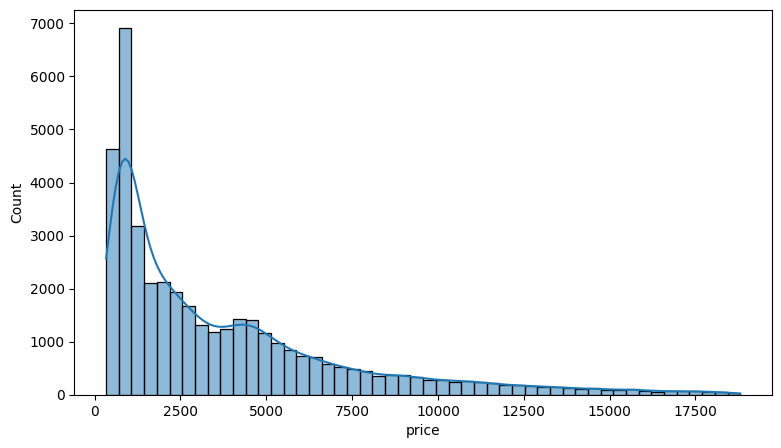

In [7]:
plt.figure(figsize=(9, 5))
sns.histplot(train["price"], bins=50, kde=True)
plt.show()

In [8]:
train[train['price'] <= 10000]

,id,carat,cut,color,clarity,depth,table,x,y,z,theta1,theta2,price
0,17044,0.28,Ideal,F,VVS2,61.6,55.0,4.22,4.26,2.61,5,5,612
1,30625,0.28,Ideal,I,VS1,62.5,54.0,4.18,4.23,2.63,5,6,448
2,17043,0.28,'Very Good',F,IF,62.2,55.0,4.23,4.26,NaN,5,7,612
3,37947,0.28,'Very Good',E,VS2,63.0,59.0,4.11,4.15,2.60,5,8,487
4,30626,0.28,Ideal,I,VS1,62.4,54.0,4.18,4.19,2.61,5,9,448
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40391,15865,2.02,Fair,G,I1,68.0,55.0,7.77,7.72,5.27,24,10,6346
40394,15866,2.02,Fair,G,I1,65.6,57.0,7.87,7.80,5.15,24,20,6346
40399,21786,2.02,Fair,J,SI2,64.6,55.0,7.93,7.84,5.09,24,26,9853
40428,20877,2.02,Fair,J,SI2,67.5,59.0,7.76,7.65,5.20,26,18,9095


Можем заметить, что объектов, у которых price > 10000, достаточно мало. Однако их присутствие в итоговых данных может повлиять на результат. Нужно избавиться от них.

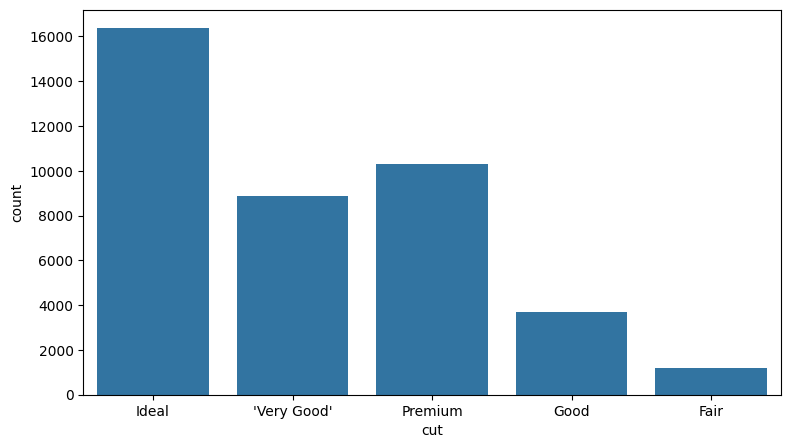

In [9]:
plt.figure(figsize=(9, 5))
sns.countplot(data=train, x="cut")
plt.show()

График показывает, что категории Ideal и Premium имеют самые высокие значения, в то время как Good и Fair — самые низкие. Большая часть алмазов в выборке имеет высокое качество огранки. Из интернета я узнал, что существует градация от Ideal до Fair. Следовательно, этот признак можно закодировать как числовой (где Ideal = 4, а Fair = 0).

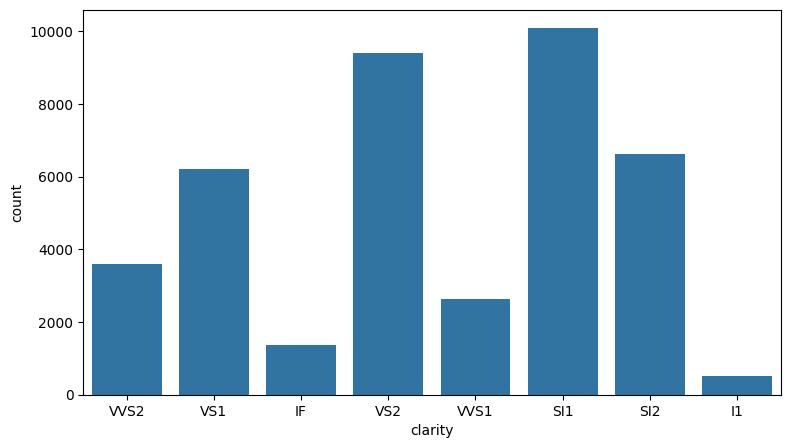

In [10]:
plt.figure(figsize=(9, 5))
sns.countplot(data=train, x="clarity")
plt.show()

Категории clarity распределены так, что большая часть значений сосредоточена в центре, а на крайних уровнях — значительно меньше (от IF до I1). Из интернета я узнал, что существует градация от IF до I1. Следовательно, этот признак можно закодировать как числовой (где IF = 7, а I1 = 0).

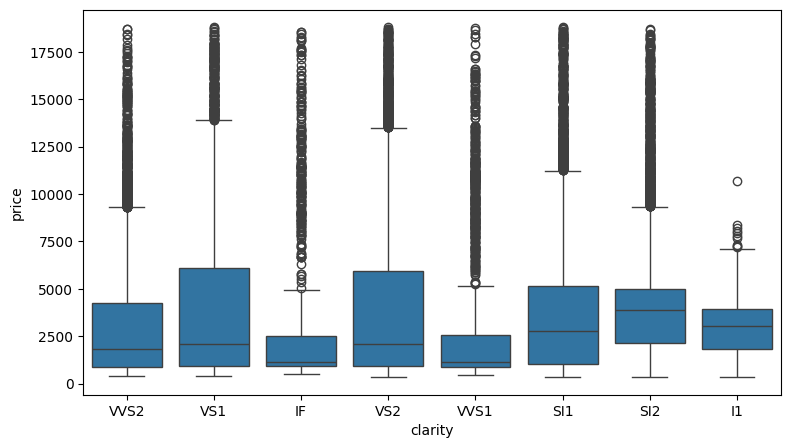

In [11]:
# Связь категориальных признаков с ценой
plt.figure(figsize=(9, 5))
sns.boxplot(data=train, x="clarity", y="price")
plt.show()

Из графика сверху видно, что «Ящики» увеличиваются к средним уровням чистоты, а затем уменьшаются. Медиана цены для категории IF ниже, чем у I1, и постепенно увеличивается до SI2. Категория clarity важна, но не является единственным предиктором цены.

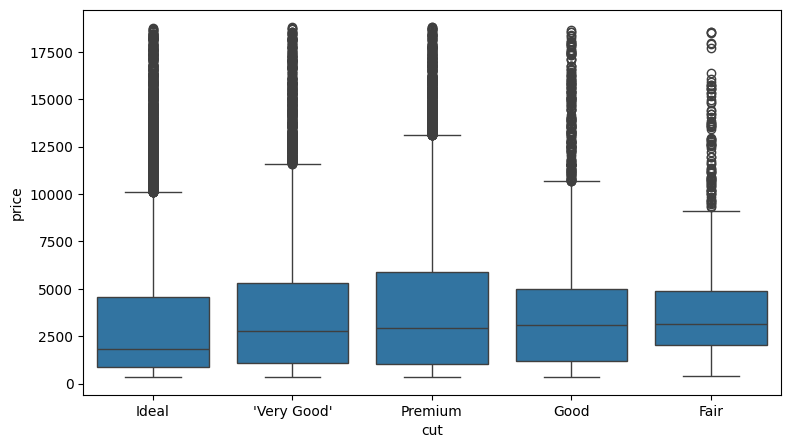

In [12]:
plt.figure(figsize=(9, 5))
sns.boxplot(data=train, x="cut", y="price")
plt.show()

Высокое качество огранки связано с более высокой ценой, однако различия между категориями Ideal, Very Good и Premium незначительны. Наименьшие цены наблюдаются в категории Fair, но даже в этой группе встречаются дорогие экземпляры.

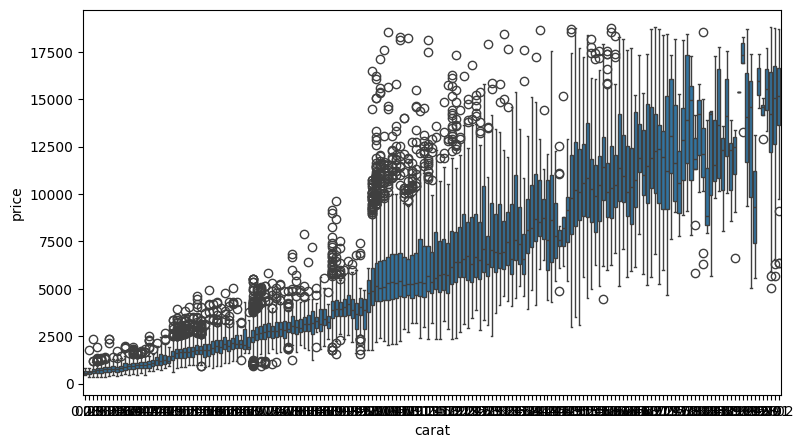

In [13]:
plt.figure(figsize=(9, 5))
sns.boxplot(data=train, x="carat", y="price")
plt.show()

Наблюдается сильная взаимосвязь между carat и price: рост цены с увеличением веса хорошо выражен. Присутствуют выбросы, от которых следует избавиться.

In [14]:
train["cut"].unique() # все уникальные значения cut

array(['Ideal', "'Very Good'", 'Premium', 'Good', 'Fair'], dtype=object)

In [15]:
train["clarity"].unique() # все уникальные значения clarity

array(['VVS2', 'VS1', 'IF', 'VS2', 'VVS1', 'SI1', 'SI2', nan, 'I1'],
      dtype=object)

In [16]:
train["color"].unique() # все уникальные значения cut

array(['F', 'I', 'E', 'H', 'D', 'G', 'J'], dtype=object)

In [17]:
train[train.columns[(train.dtypes != "object").values]].describe() # описание числовых признаков

,id,carat,depth,table,x,y,z,theta1,theta2,price
count,40453.000000,40453.00000,40396.000000,40453.000000,40405.000000,40393.000000,40411.000000,40453.000000,40453.000000,40453.000000
mean,26946.030529,0.77475,61.755897,57.438563,5.704927,18.773722,3.523399,19.071738,19.036190,3736.247003
std,15761.901131,0.41728,1.425065,2.225439,1.033411,350.627591,0.656404,8.527417,8.570144,3615.804536
min,3.000000,0.28000,43.000000,43.000000,0.000000,0.000000,0.000000,5.000000,5.000000,334.000000
25%,13160.000000,0.40000,61.100000,56.000000,4.740000,4.750000,2.930000,11.000000,11.000000,979.000000
50%,27038.000000,0.70000,61.800000,57.000000,5.700000,5.710000,3.520000,19.000000,19.000000,2401.000000
75%,40768.000000,1.03000,62.500000,59.000000,6.510000,6.510000,4.020000,27.000000,27.000000,5154.000000
max,53939.000000,2.02000,79.000000,79.000000,8.800000,9428.922353,31.800000,33.000000,33.000000,18803.000000


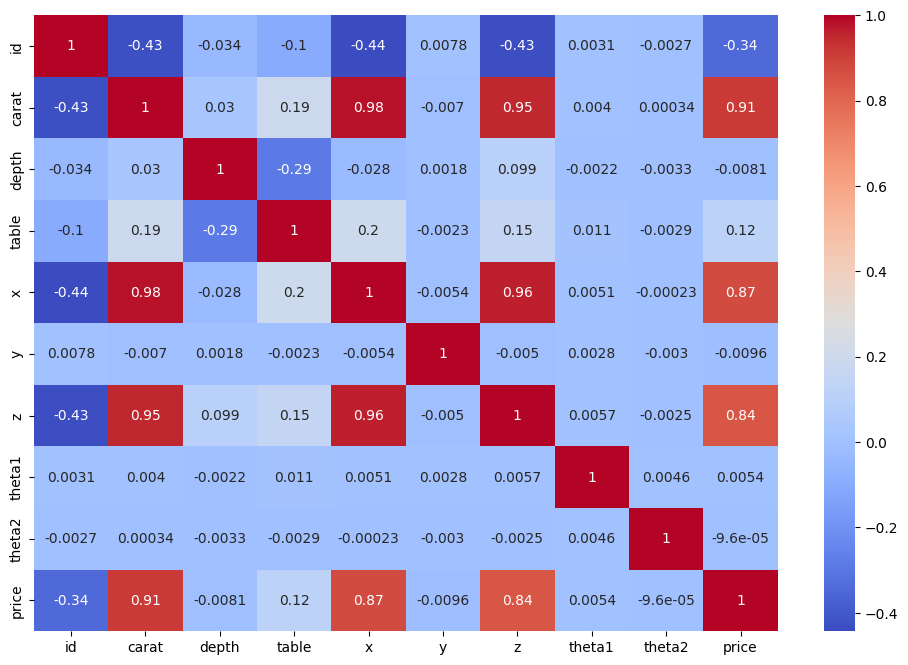

In [18]:
#Построение матрицы корреляции
corr_matrix = train[train.columns[(train.dtypes != "object").values]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

Корреляция между carat и price составляет 0.91, что указывает на сильную положительную взаимосвязь. Это означает, что с увеличением веса алмаза цена, как правило, также растёт.

Наименьшая корреляция наблюдается с depth (-0.0081), что указывает на наличие очень слабой негативной связи.

Стоит помнить о выбросах, которые могут искажать нашу матрицу корреляций.

### Preprocessing (подготовка данных)

 В этом разделе вам необходимо реализовать подготовку ваших данных, в том числе заполнение пропусков, фильтрацию выбросов, кодирование категориальных признаков и т.д. В этот же раздел включите любые операции над данными, которые сочтете нужными.

In [19]:
# preprocessing pipeline

# Оставим только те объекты, у которых price меньше или равна 10,000
filtered_train = train[train['price'] <= 10000]

# Разобьём наши признаки на категориальные и числовые (+id).
categorical_cols = ["cut", "color", "clarity"]
numeric_cols = ["carat", "depth", "table", "x", "y", "z", "theta1", "theta2"]
id = ["id"]

В коде ниже я хотел избавиться от выбросов в признаке carat, но это не понадобилось.

In [20]:
#columns = ['carat']
#
#for column in columns:
#    Q1 = train[column].quantile(0.25)
#    Q3 = train[column].quantile(0.75)
#    IQR = Q3 - Q1
#   lower_bound = max(0, Q1 - 1.5 * IQR)  # Нижняя граница ограничена нулем
#    upper_bound = Q3 + 1.5 * IQR
#
#    # Удаление выбросов по текущему признаку
#    train = train[(train[column] >= lower_bound) & (train[column] <= upper_bound)]

In [21]:
# Разделение на признаки и целевую переменную
X = filtered_train[categorical_cols + id + numeric_cols]
y = filtered_train["price"]
test = test[categorical_cols + id + numeric_cols]


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train

,cut,color,clarity,id,carat,depth,table,x,y,z,theta1,theta2
12372,Ideal,H,VVS2,36478,0.43,61.3,56.0,4.86,4.90,2.99,15,28
5763,'Very Good',H,IF,32172,0.33,61.7,59.0,4.43,4.45,2.74,11,11
37871,Fair,H,SI1,18292,1.52,64.6,55.0,7.24,7.19,4.66,30,11
6594,Ideal,H,VS1,31477,0.34,62.3,55.0,4.48,4.45,2.78,8,16
23994,Premium,F,SI2,837,0.82,59.7,57.0,6.14,6.12,3.66,5,28
...,...,...,...,...,...,...,...,...,...,...,...,...
16850,Ideal,J,SI1,39863,0.55,61.0,56.0,5.31,5.34,3.25,24,20
6265,Premium,I,VVS2,7406,0.33,61.5,58.0,4.43,4.45,2.73,15,21
11284,Ideal,G,SI1,29076,0.41,61.7,54.0,4.78,4.81,2.96,30,28
860,Premium,G,VVS1,32274,0.30,60.5,59.0,4.33,4.36,2.63,33,11


In [24]:
X_val

,cut,color,clarity,id,carat,depth,table,x,y,z,theta1,theta2
12519,Ideal,D,VS2,40680,0.44,60.4,56.0,4.95,4.91,2.98,25,31
20068,Ideal,J,SI2,48949,0.70,61.6,57.0,5.73,5.69,3.52,5,25
24925,'Very Good',D,SI1,7849,0.90,63.3,57.0,6.12,6.07,3.86,9,24
27421,Premium,F,VS2,16617,1.00,61.9,59.0,6.41,6.36,3.95,31,5
15039,Ideal,G,VS2,50397,0.52,62.0,55.0,5.16,5.19,3.21,19,14
...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Ideal,F,VVS1,35982,0.31,62.4,55.0,4.32,4.34,2.70,18,10
18754,'Very Good',G,VS1,50826,0.67,59.9,57.4,5.69,5.75,3.42,5,11
26454,'Very Good',I,SI2,52787,0.97,63.4,58.0,6.34,6.20,3.98,25,7
3517,'Very Good',J,SI1,28278,0.31,62.7,59.0,4.29,4.32,2.70,6,33


In [25]:
y_train

12372     943
5763      787
37871    7433
6594      765
23994    2867
         ... 
16850    1101
6265      579
11284     688
860       789
15795    1769
Name: price, Length: 29843, dtype: int64

Заполняем пропуски средним значением и масштабируем числовые признаки.

In [26]:
num_imp = SimpleImputer(strategy="mean")

In [27]:
X_train[numeric_cols] = num_imp.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = num_imp.transform(X_val[numeric_cols])
test[numeric_cols] = num_imp.transform(test[numeric_cols])

In [28]:
scaler = StandardScaler()

In [29]:
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

Заполняем пропуски в категориальных признаках наиболее частым значением.

In [30]:
cat_imp = SimpleImputer(strategy="most_frequent")

In [31]:
X_train[categorical_cols] = cat_imp.fit_transform(X_train[categorical_cols])
X_val[categorical_cols] = cat_imp.transform(X_val[categorical_cols])
test[categorical_cols] = cat_imp.transform(test[categorical_cols])

Кодируем категориальные признаки.

In [32]:
cut_mapping = {              # Используем мапу с данными, взятыми из интернета, где Ideal имеет самый большой вес
    "Fair": 0,
    "Good": 1,
    "'Very Good'": 2,        # Достаточно долго не мог найти ошибку из-за кавычек
    "Premium": 3,
    "Ideal": 4
}

X_train["cut"] = X_train["cut"].map(cut_mapping)
X_val["cut"] = X_val["cut"].map(cut_mapping)
test["cut"] = test["cut"].map(cut_mapping)

clarity_mapping = {            # Используем мапу с данными, взятыми из интернета, где IF имеет самый большой вес
    "I1": 0,
    "SI2": 1,
    "SI1": 2,
    "VS2": 3,
    "VS1": 4,
    "VVS2": 5,
    "VVS1": 6,
    "IF": 7
}

X_train["clarity"] = X_train["clarity"].map(clarity_mapping)
X_val["clarity"] = X_val["clarity"].map(clarity_mapping)
test["clarity"] = test["clarity"].map(clarity_mapping)

В коде ниже я хотел избавиться от выбросов в различных числовых признаках. Сначала я просто удалял выбросы, затем применял логарифм. В итоге на train'е было лучшее решение, но на test'е, то есть на Kaggle, выгоднее этого не делать.

In [33]:
#features = ["carat", "clarity", "cut", "theta1", "theta2",]
#features = ["theta1", "theta2",]

#for feature in features:
#    Q1 = X_train[feature].quantile(0.25)
#    Q3 = X_train[feature].quantile(0.75)
#    IQR = Q3 - Q1
#    lower_bound = Q1 - 1.5 * IQR
#    upper_bound = Q3 + 1.5 * IQR
#
#    X_train[feature] = X_train[feature].apply(lambda x: np.log(x + 1) if x < lower_bound or x > upper_bound else x)
#
#for feature in features:
#    Q1 = X_val[feature].quantile(0.25)
#    Q3 = X_val[feature].quantile(0.75)
#    IQR = Q3 - Q1
#    lower_bound = Q1 - 1.5 * IQR
#    upper_bound = Q3 + 1.5 * IQR
#
#    X_val[feature] = X_val[feature].apply(lambda x: np.log(x + 1) if x < lower_bound or x > upper_bound else x)

Преобразуем категориальный признак color в числовой с помощью one-hot-кодирования.

In [34]:
X_train = pd.get_dummies(X_train, columns = ["color"])
X_val = pd.get_dummies(X_val, columns = ["color"])
test = pd.get_dummies(test, columns = ["color"])

In [35]:
X_train[X_train.columns[(X_train.dtypes != "object").values]].describe()

,cut,clarity,id,carat,depth,table,x,y,z,theta1,theta2
count,29843.000000,29843.000000,29843.000000,2.984300e+04,2.984300e+04,2.984300e+04,2.984300e+04,2.984300e+04,2.984300e+04,2.984300e+04,2.984300e+04
mean,2.916429,3.029622,27154.626278,3.566642e-16,5.203536e-15,-2.671529e-15,-1.897606e-16,-4.523778e-18,1.252372e-16,1.207135e-16,-1.775583e-16
std,1.119967,1.627187,16395.296449,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,0.000000,0.000000,3.000000,-1.221561e+00,-1.250708e+01,-6.470318e+00,-5.996053e+00,-5.412869e-02,-5.726912e+00,-1.639689e+00,-1.640758e+00
25%,2.000000,2.000000,12106.000000,-8.779246e-01,-4.678126e-01,-6.302885e-01,-9.267387e-01,-4.124748e-02,-8.908542e-01,-9.378753e-01,-9.409859e-01
50%,3.000000,3.000000,29520.000000,-1.620161e-01,2.502299e-02,-1.810555e-01,-9.947834e-03,-3.895019e-02,-4.037515e-02,-2.124355e-03,-7.956838e-03
75%,4.000000,4.000000,41790.500000,8.688922e-01,5.178585e-01,7.174105e-01,8.960572e-01,-3.665290e-02,8.768081e-01,9.336266e-01,9.250722e-01
max,4.000000,7.000000,53939.000000,3.761163e+00,1.213470e+01,9.702071e+00,2.956140e+00,2.573271e+01,4.730296e+01,1.635440e+00,1.624844e+00


Из-за масштабирования некоторые значения стали довольно странными.

Ниже я проверял все остальное

In [36]:
X_train

,cut,clarity,id,carat,depth,table,x,y,z,theta1,theta2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
12372,4,5,36478,-0.792016,-0.327002,-0.630289,-0.754166,-0.040728,-0.740770,-0.470000,1.041701,False,False,False,False,True,False,False
5763,2,7,32172,-1.078379,-0.045382,0.717411,-1.217955,-0.041959,-1.157671,-0.937875,-0.940986,False,False,False,False,True,False,False
37871,0,2,18292,2.329346,1.996365,-1.079522,1.812848,-0.034465,2.044132,1.284533,-0.940986,False,False,False,False,True,False,False
6594,4,4,31477,-1.049743,0.377048,-1.079522,-1.164026,-0.041959,-1.090967,-1.288782,-0.357843,False,False,False,False,True,False,False
23994,3,1,837,0.324802,-1.453484,-0.181056,0.626413,-0.037391,0.376526,-1.639689,1.041701,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,4,2,39863,-0.448380,-0.538218,-0.630289,-0.268806,-0.039525,-0.307192,0.582720,0.108672,False,False,False,False,False,False,True
6265,3,5,7406,-1.078379,-0.186192,0.268177,-1.217955,-0.041959,-1.174347,-0.470000,0.225300,False,False,False,False,False,True,False
11284,4,2,29076,-0.849288,-0.045382,-1.528755,-0.840452,-0.040974,-0.790798,1.284533,1.041701,False,False,False,True,False,False,False
860,3,6,32274,-1.164288,-0.890243,0.717411,-1.325812,-0.042205,-1.341108,1.635440,-0.940986,False,False,False,True,False,False,False


In [37]:
X_train.isnull().sum()

cut        0
clarity    0
id         0
carat      0
depth      0
table      0
x          0
y          0
z          0
theta1     0
theta2     0
color_D    0
color_E    0
color_F    0
color_G    0
color_H    0
color_I    0
color_J    0
dtype: int64

In [38]:
X_train["cut"].unique()

array([4, 2, 0, 3, 1])

Признак id стал типа float, поэтому я исправил его на int.

In [39]:
X_train = X_train.astype({"id": "int"})
X_val = X_val.astype({"id": "int"})
test = test.astype({"id": "int"})

In [40]:
X_train

,cut,clarity,id,carat,depth,table,x,y,z,theta1,theta2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
12372,4,5,36478,-0.792016,-0.327002,-0.630289,-0.754166,-0.040728,-0.740770,-0.470000,1.041701,False,False,False,False,True,False,False
5763,2,7,32172,-1.078379,-0.045382,0.717411,-1.217955,-0.041959,-1.157671,-0.937875,-0.940986,False,False,False,False,True,False,False
37871,0,2,18292,2.329346,1.996365,-1.079522,1.812848,-0.034465,2.044132,1.284533,-0.940986,False,False,False,False,True,False,False
6594,4,4,31477,-1.049743,0.377048,-1.079522,-1.164026,-0.041959,-1.090967,-1.288782,-0.357843,False,False,False,False,True,False,False
23994,3,1,837,0.324802,-1.453484,-0.181056,0.626413,-0.037391,0.376526,-1.639689,1.041701,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,4,2,39863,-0.448380,-0.538218,-0.630289,-0.268806,-0.039525,-0.307192,0.582720,0.108672,False,False,False,False,False,False,True
6265,3,5,7406,-1.078379,-0.186192,0.268177,-1.217955,-0.041959,-1.174347,-0.470000,0.225300,False,False,False,False,False,True,False
11284,4,2,29076,-0.849288,-0.045382,-1.528755,-0.840452,-0.040974,-0.790798,1.284533,1.041701,False,False,False,True,False,False,False
860,3,6,32274,-1.164288,-0.890243,0.717411,-1.325812,-0.042205,-1.341108,1.635440,-0.940986,False,False,False,True,False,False,False


In [41]:
test

,cut,clarity,id,carat,depth,table,x,y,z,theta1,theta2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,4,2,14085,1.527528,-0.327002,-0.630289,1.446132,-0.035176,1.343738,-1.639689,-1.640758,False,False,False,False,False,True,False
1,4,3,36447,-1.135652,0.236238,-1.528755,-1.282669,-0.042287,-1.224375,-1.639689,-1.524129,True,False,False,False,False,False,False
2,2,4,30782,-0.906561,-0.045382,2.065110,-0.980668,-0.041302,-0.924206,-1.639689,-1.407500,False,False,False,True,False,False,False
3,4,1,43299,-0.276561,-0.467813,-0.181056,-0.107020,-0.039114,-0.157108,-1.639689,-1.290872,False,False,False,False,False,True,False
4,1,1,3378,-1.135652,1.010694,-1.079522,-1.347384,-0.042287,-1.174347,-1.639689,-1.174243,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13482,3,0,25999,9.459795,0.517859,2.065110,4.811293,-0.026944,4.678950,1.401502,1.274958,False,False,False,False,False,False,True
13483,3,0,25998,9.459795,-0.538218,1.615877,4.940723,-0.026507,4.562217,1.401502,1.624844,False,False,False,False,False,True,False
13484,0,0,27130,9.803431,2.137175,1.615877,4.789722,-0.027190,4.995795,1.518471,-1.640758,False,False,False,False,True,False,False
13485,0,0,27630,10.862976,2.841226,0.268177,5.037795,-0.026342,5.479401,1.518471,-0.940986,False,False,False,False,False,False,True


### Model & training (Выбор модели и её обучение)

В этом разделе описываете модель и ставите эксперименты по обучению.

Если вы ставили много экспериментов, приведите их в хронологическом порядке чтобы мы увидели эволюцию ваших рассуждений.

#### Эксперимент 1

Поскольку задание связано с линейной регрессией, я решил сначала выбрать её для обучения.

In [42]:
# some code and comments

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [43]:
y_pred = model.predict(X_val)

In [44]:
mae = mean_absolute_error(y_val, y_pred)
mae

np.float64(486.73639731051213)

Несмотря на все мои манипуляции с данными, я не смог добиться положительного результата, поэтому решил использовать другую модель.

#### Эксперимент 2

Я выбрал модель Ridge. Поскольку я не знал, как работает эта модель, решил разобраться и использовать её для лабораторной работы.

In [45]:
# some code and comments
ridge = Ridge(alpha=1.0)

ridge.fit(X_train, y_train)

Ridge()

In [46]:
y_pred = ridge.predict(X_val)

In [47]:
mae = mean_absolute_error(y_val, y_pred)
mae

np.float64(486.7998031917812)

Я использовал разные аргументы, но ни один из результатов не дал нужного значения.

In [48]:
ridge = Ridge(alpha=0.1)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mae

np.float64(486.74273338604723)

In [49]:
ridge = Ridge(alpha=10)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mae

np.float64(487.3763647304865)

#### Эксперимент 3

В этот момент я решил исследовать все линейные модели и нашел комбинацию линейной регрессии с полиномиальными признаками.

In [50]:
# some code and comments
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)

In [51]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_poly, y_train)

LinearRegression()

In [52]:
y_pred = poly_reg_model.predict(X_val_poly)

In [53]:
mae = mean_absolute_error(y_val, y_pred)
mae

np.float64(286.26888578108515)

Но, к сожалению, я не смог полностью разобраться в работе с полиномиальными признаками.

#### Эксперимент 4

Я решил остановиться на Lasso, так как эта модель может помочь улучшить качество предсказания, отбирая только те признаки, которые действительно влияют на стоимость алмаза.

In [54]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [55]:
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

c:\Users\yarov\ml-dist-mipt\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e+07, tolerance: 1.369e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\yarov\ml-dist-mipt\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+07, tolerance: 1.354e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\yarov\ml-dist-mipt\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_absolute_error')

In [56]:
best_alpha = grid_search.best_params_['alpha']
print(f"Лучшее значение alpha: {best_alpha}")

Лучшее значение alpha: 0.001


In [57]:
best_lasso_model = Lasso(alpha=best_alpha)
best_lasso_model.fit(X_train, y_train)

c:\Users\yarov\ml-dist-mipt\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e+07, tolerance: 1.710e+07
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

In [58]:
y_pred = best_lasso_model.predict(X_val)

In [59]:
mae = mean_absolute_error(y_val, y_pred)
mae

np.float64(486.73709893385416)

In [60]:
test_predict = best_lasso_model.predict(test)

In [61]:
submission = pd.DataFrame({"id": test.id, "price": test_predict})

submission.to_csv("submission.csv", index=False)

### Evaluation (оценка качества модели)

В этом разделе проводите оценку качества вашей итоговой модели. 

In [62]:
# model evaluation
mae = mean_absolute_error(y_val, y_pred)
mae

np.float64(486.73709893385416)

Я смог добиться результата MAE = 486.807 (на Kaggle — 687.819), который меня устраивает.

### Conclusion (Выводы)

В этом разделе описываете полученные результаты и проводите анализ выполненной работы. 
Что получилось / не получилось и почему?

В ходе выполнения лабораторной работы была разработана модель машинного обучения, которая использует характеристики алмазов для предсказания их стоимости на рынке.

Перед обучением модели была проведена работа с исходными данными: проверка на наличие пропусков, обработка категориальных признаков и масштабирование числовых параметров. Были учтены все характеристики алмазов, чтобы получить максимально точные предсказания.

Я изучил большое количество линейных моделей.

Однако я не понимал, почему удалось получить более точное решение на Kaggle без обработки выбросов. Стоит изучить этот момент более подробно.